Epoch 1/5, Loss: 0.0083
Epoch 2/5, Loss: 0.0032
Epoch 3/5, Loss: 0.0031
Epoch 4/5, Loss: 0.0030
Epoch 5/5, Loss: 0.0029


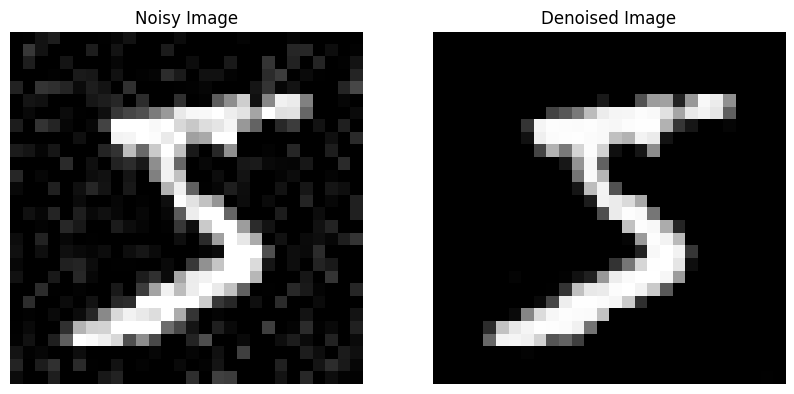

Noise Features: [[-1.2966846  -2.2077382   0.8907294  -1.749484    1.7233001  -0.07684061
   0.7855685   1.3372616 ]]
Denoised Image Shape: torch.Size([1, 1, 28, 28])


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Lightweight CNN-based Noise Estimator
class NoiseEstimator(nn.Module):
    def __init__(self):
        super(NoiseEstimator, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(32, 8)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Hypernetwork
class HyperNetwork(nn.Module):
    def __init__(self, noise_feature_size=8, denoiser_weight_size=288):  # Changed from 160 to 288
        super(HyperNetwork, self).__init__()
        self.fc1 = nn.Linear(noise_feature_size, 128)
        self.fc2 = nn.Linear(128, denoiser_weight_size)

    def forward(self, noise_features):
        x = F.relu(self.fc1(noise_features))
        weights = self.fc2(x)
        return weights

# Updated Denoiser
class Denoiser(nn.Module):
    def __init__(self):
        super(Denoiser, self).__init__()
        self.conv1_channels = 1
        self.conv2_channels = 16
        self.out_channels = 1

    def forward(self, x, weights):
        w1_size = self.conv2_channels * self.conv1_channels * 3 * 3  # 16 * 1 * 3 * 3 = 144
        w1 = weights[0, :w1_size].reshape(self.conv2_channels, self.conv1_channels, 3, 3)
        w2 = weights[0, w1_size:].reshape(self.out_channels, self.conv2_channels, 3, 3)  # 1 * 16 * 3 * 3 = 144
        x = F.conv2d(x, w1, padding=1, stride=1)
        x = F.relu(x)
        x = F.conv2d(x, w2, padding=1, stride=1)
        x = torch.sigmoid(x)
        return x

# Temperature Scaling for Calibration
class TemperatureScaling(nn.Module):
    def __init__(self, temperature=1.5):
        super(TemperatureScaling, self).__init__()
        self.temperature = nn.Parameter(torch.ones(1) * temperature)

    def forward(self, logits):
        return logits / self.temperature

# Full Model
class HyperDenoisingModel(nn.Module):
    def __init__(self):
        super(HyperDenoisingModel, self).__init__()
        self.noise_estimator = NoiseEstimator()
        self.hypernetwork = HyperNetwork()
        self.denoiser = Denoiser()
        self.calibration = TemperatureScaling()

    def forward(self, noisy_img):
        noise_features = self.noise_estimator(noisy_img)
        weights = self.hypernetwork(noise_features)
        denoised_img = self.denoiser(noisy_img, weights)
        calibrated_output = self.calibration(denoised_img)
        return calibrated_output, noise_features

# Training and Testing
def add_noise(img, noise_level=0.1):
    noise = torch.randn_like(img) * noise_level
    return torch.clamp(img + noise, 0, 1)

def train(model, train_loader, epochs=5, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_idx, (clean_img, _) in enumerate(train_loader):
            clean_img = clean_img.to(device)
            noisy_img = add_noise(clean_img).to(device)
            optimizer.zero_grad()
            denoised_img, _ = model(noisy_img)
            loss = criterion(denoised_img, clean_img)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

# Load sample dataset (MNIST)
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize and train the model
model = HyperDenoisingModel().to(device)
train(model, train_loader)

# Test on a single image and display results
model.eval()
with torch.no_grad():
    test_img, _ = train_dataset[0]
    noisy_img = add_noise(test_img.unsqueeze(0)).to(device)
    denoised_img, noise_features = model(noisy_img)

    # Convert tensors to numpy for visualization
    noisy_img_np = noisy_img.squeeze().cpu().numpy()
    denoised_img_np = denoised_img.squeeze().cpu().numpy()

    # Plot original (noisy) and denoised images
    plt.figure(figsize=(10, 5))

    # Display noisy image
    plt.subplot(1, 2, 1)
    plt.imshow(noisy_img_np, cmap='gray')
    plt.title("Noisy Image")
    plt.axis('off')

    # Display denoised image
    plt.subplot(1, 2, 2)
    plt.imshow(denoised_img_np, cmap='gray')
    plt.title("Denoised Image")
    plt.axis('off')

    plt.show()

    print("Noise Features:", noise_features.cpu().numpy())
    print("Denoised Image Shape:", denoised_img.shape)